In [1]:
from functions import bresenham,detection_points,reduce_points,histogram_distribution,get_density,plot_density,hair_removal 
import yaml
import os
import cv2 

import warnings
warnings.filterwarnings("ignore")

## Load config file
This part loads the parameters from the config file

In [2]:
parameters=yaml.safe_load(open('config001.yaml'))

image_path=parameters.get('image_path')
processed_image_path=parameters.get('processed_image_path')

## Override variables
Here you can override the default variables from the config file.


In [3]:
# Declare width and height of the patches
r=6

#Set canny parameters
canny_A = 100
canny_B = 100
aperture = 3
L2gradient = False

#Set HoughlinesP parameters
hough_method = 'cv2.HOUGH_PROBABILISTIC' 
hough_resolution = 720   # the resolution of rho in degrees
hough_threshold  = 35    # number of required votes
hough_min_length = 1     # the minimum line length
hough_max_gap    = 15    # maximum allowed gap
hough_iter       = 16    # number of iterations

# Set Thresholds
max_lines_cap           = 99    # Check density above this cap
max_density_cap         = 123   # Check density history variance above this cap
max_hist_variance       = 30    # Maximum allowed density history variance
max_hist_variance_cap   = 5     # Even distribution below this threshold
max_std_dev_cap         = 0.30  # Even distribution below this threshold
max_variance_cap        = 0.10  # Even distribution below this threshold


Uncomment this line if you want to override the variables. Otherwise the default variables from config001.yml will be used


In [ ]:
#parameters={"r": r, "canny_A": canny_A, "canny_B": canny_B, "aperture": aperture, "L2gradient": L2gradient,"max_lines_cap": max_lines_cap,"max_density_cap": max_density_cap,"max_hist_variance":max_hist_variance,"max_hist_variance_cap":max_hist_variance_cap,"max_std_dev_cap":max_std_dev_cap,"max_variance_cap":max_variance_cap,"hough_method":hough_method,"hough_resolution":hough_resolution,"hough_threshold":hough_threshold,"hough_min_length":hough_min_length,"hough_max_gap":hough_max_gap,"hough_iter":hough_iter}

## Functions

These functions are called from witin the `hair_removal()` function

- bresenham : to calculate intermediate points in a line
- detection_points : create a list of all coordinates to patch
- reduce_points : to remove adjacent points (optional)
- histogram_distribution : returns the variance in the density histogram
- get_density : calculates density in a gridsize grid
- plot_density : plots the density grid and the density histogram
- hair_removal : processes and writes processed images (detected lines and patched image)

You can find these in the `functions.py` file in the same folder


## Process

This block iterates over all the files in the default images folder and processes them.

ISIC_0024306.jpg


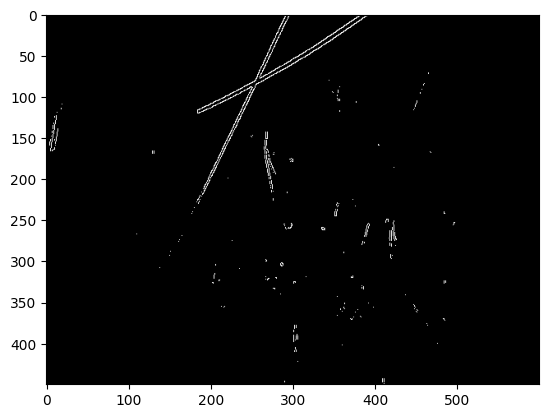

12 lines detected
Maximum density : 27.0
Histogram variance is: 38.25 The densities are not evenly distributed
---- HAIRS DETECTED ----


In [4]:
for image_file in os.listdir(image_path):

    # Print the name of the current file
    print (image_file)

    # Read the image
    image = cv2.imread(os.path.join(image_path,image_file))
    
    # Process the image
    processed_image, clean_processed_image= hair_removal(image,**parameters)
    
    # Save image with the detected lines 
    # cv2.imwrite(os.path.join(processed_image_path,'phough',f'p{image_file}'), processed_image) 

    # Save processed image
    cv2.imwrite(os.path.join(processed_image_path,image_file), clean_processed_image)  
